### This is the same notebook as analyze_sql_data.ipynb but includes multiple years

In [337]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np

from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
                            accuracy_score, 
                            precision_score, 
                            recall_score, 
                            f1_score, 
                            roc_curve, 
                            roc_auc_score, 
                            confusion_matrix
                            )
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import confusion_matrix

from unbalanced_dataset import OverSampler, SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [338]:
CONFIG = {}

with open('config.txt', "r") as in_file:
    for line in in_file:
        line = line.split(":")
        parameter = line[0].strip()
        value = line[1].strip()
        CONFIG[parameter] = value
                
engine_path = 'postgresql://'+CONFIG['username']+':'+\
                CONFIG['password']+'@'+CONFIG['ip']+\
                ':'+CONFIG['port']+'/'+CONFIG['database']
        
engine = create_engine(engine_path)

### Want something like:

    SELECT
        table4.countrycode as 'countrycode',
        b.table1 as 'table1',
        b.table2 as 'table2',
        b.table3 as 'table3',
        table4.year as 'table4'
        (SELECT
            table3.countrycode as 'countrycode',
            a.table1 as 'table1',
            a.table2 as 'table2',
            table3.year as 'table3'
         FROM
            (SELECT
                 table1.countrycode as 'countrycode',
                 table1.year as 'table1',
                 table2.year as 'table2'
             FROM
                 table1
             JOIN
                 table2
               ON 
                 table1.countrycode = table2.countrycode
             ) a
         JOIN
             table3
           ON
             a.countrycode = table3.countrycode  
        ) b    
    JOIN
        table4
      ON
        a.countrycode = table3.countrycode 
    
        
       


In [339]:
def makeSQLQuery(table_names, year):
    dotyyear = '.y' + str(year)
    current_unit = 'a'
    query = '(SELECT ' + table_names[0] + '.countrycode AS countrycode, ' + \
            table_names[0] + dotyyear + ' AS ' + table_names[0] + ', ' + \
            table_names[1] + dotyyear + ' AS ' + table_names[1] + \
            ' FROM ' + table_names[0] + \
            ' JOIN ' + table_names[1] + \
            ' ON ' + table_names[0] + '.countrycode=' + table_names[1] + '.countrycode) '
    query = query + current_unit
    
    for table in table_names[2:]:
        curr_index = table_names.index(table)
        temp_list = table_names[:curr_index+1]
        
        pre_string = '(SELECT ' + table + '.countrycode as countrycode'
        
        for temp_table in temp_list[:-1]:
            pre_string = pre_string + ', ' + current_unit + '.' + temp_table + ' AS ' + temp_table
        
        pre_string = pre_string + ', ' + table + dotyyear + ' AS ' + table
        
        query = pre_string + ' FROM ' + query + ' JOIN ' + table + \
                ' ON ' + current_unit + '.countrycode=' + table + '.countrycode) '
        
        current_unit = current_unit + 'a'
        query = query + current_unit
        
    query = query.rsplit(' ', 1)[0][1:-1]
    
    return query
    
    

## Change these to select data

In [340]:
table_names = ['civil_liberties', \
               'political_rights', \
               #'freedom_status', \
               #'corruption_perception', \
               'female_legislators', \
               'population_growth', \
               'population_female', \
               #'under_5_mortality', \
               'life_expectancy', \
               #'population_0_14', \
               'population_15_64',  \
               #'population_65_up', \
               #'terror_new', \
               #'peace_new', \
               'zscores']

In [341]:
x_cols = table_names[:-1]

In [342]:
years = [2008, 2009, 2010, 2011, 2012, 2013]

In [343]:
full_data = pd.DataFrame()

In [344]:
for year in years:
    query = makeSQLQuery(table_names, year)
    year_data = pd.read_sql_query(query, engine)
    year_data['year'] = year
    year_data = year_data.set_index(['countrycode', 'year'])
    full_data = pd.concat([full_data, year_data])
    


In [345]:
full_data.head()

,,civil_liberties,political_rights,population_growth,population_female,female_legislators,life_expectancy,population_15_64,zscores
countrycode,year,,,,,,,,
AFG,2008,6,5,2.485315,48.512909,27.7,58.225024,49.946087,6.546331355
AGO,2008,5,6,3.374180,50.493712,37.3,49.847390,49.356104,0.281696206
ALB,2008,3,3,-0.767343,49.610212,7.1,76.632317,66.816430,0.055357722
ARE,2008,5,6,13.810060,25.880062,22.5,76.307756,84.600650,-0.267222176
ARG,2008,2,2,1.025393,51.087196,40.0,75.166268,63.456290,-0.26793528


In [346]:
full_data['zscores'] = full_data['zscores'].astype(float)

full_data.loc[full_data['zscores'] > 0, 'zscores'] = 1
full_data.loc[full_data['zscores'] <= 0, 'zscores'] = 0

try:
    full_data.loc[full_data['freedom_status'] == 'F', 'freedom_status'] = -1
    full_data.loc[full_data['freedom_status'] == 'PF', 'freedom_status'] = 0
    full_data.loc[full_data['freedom_status'] == 'NF', 'freedom_status'] = 1
except:
    pass


In [347]:
#The rows to be dropped
full_data[full_data.isnull().any(axis=1)]

,,civil_liberties,political_rights,population_growth,population_female,female_legislators,life_expectancy,population_15_64,zscores
countrycode,year,,,,,,,,
FJI,2008,4,6,1.010417,48.947707,NaN,69.022024,65.706245,0
GIN,2008,5,7,2.671069,49.966108,NaN,54.777585,53.134073,0
LUX,2008,1,1,1.787497,50.493425,23.3,80.539024,67.877191,NaN
MMR,2008,7,7,0.651129,51.176312,NaN,64.367610,64.768113,0
SSD,2008,NaN,NaN,4.362664,50.051550,NaN,52.593317,52.863172,NaN
TKM,2008,7,7,1.213341,50.724437,NaN,64.756073,65.247102,0
VUT,2008,2,2,2.416066,49.142388,3.8,70.254756,57.801496,NaN
FJI,2009,4,6,1.020386,48.947824,NaN,69.202854,65.938529,0
GIN,2009,6,7,2.728375,49.955495,NaN,55.556146,53.333078,0


In [348]:
full_data = full_data.dropna()

In [349]:
#Get Z scores of rows
for col in x_cols:
    full_data[col] = full_data[col].astype(float)
    full_data[col] = (full_data[col] - full_data[col].mean())/full_data[col].std(ddof=0)


#### Get the score values WITHOUT cross validating 

In [350]:
def getScoreValues(X_train, 
                   X_test, 
                   y_train, 
                   y_test, 
                   model=KNeighborsClassifier(n_neighbors=6), 
                   verbose=True, 
                   get_features=True
                  ):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    
    
    accuracy_score_value = accuracy_score(y_test, y_pred)
    precision_score_value = precision_score(y_test, y_pred)
    recall_score_value = recall_score(y_test, y_pred)
    f1_score_value = f1_score(y_test, y_pred)  
    
    feature_importances = None
    if get_features:
        try:
            feature_importances = model.feature_importances_
            #print(feature_importances)
        except AttributeError:
            pass
    
    if verbose:
        #print(pd.concat([y_test,pd.Series(y_pred, index=y_test.index)], axis = 1))
        print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(accuracy_score_value, \
                                                                       precision_score_value, \
                                                                       recall_score_value, \
                                                                       f1_score_value))
    else:
        return accuracy_score_value, precision_score_value, recall_score_value, f1_score_value, feature_importances

In [351]:
X = full_data[x_cols]
y = full_data['zscores']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [352]:
getScoreValues(X_train, X_test, y_train, y_test, DecisionTreeClassifier())

Accuracy: 0.9047619047619048
Precision: 0.6530612244897959
Recall: 0.7111111111111111
f1: 0.6808510638297872


In [353]:
getScoreValues(X_train, X_test, y_train, y_test, BernoulliNB())

Accuracy: 0.8063492063492064
Precision: 0.3620689655172414
Recall: 0.4666666666666667
f1: 0.4077669902912621


In [354]:
getScoreValues(X_train, X_test, y_train, y_test, GaussianNB())

Accuracy: 0.7492063492063492
Precision: 0.3111111111111111
Recall: 0.6222222222222222
f1: 0.4148148148148148


In [355]:
getScoreValues(X_train, X_test, y_train, y_test, model=SVC())

Accuracy: 0.8698412698412699
Precision: 0.6666666666666666
Recall: 0.17777777777777778
f1: 0.2807017543859649


In [356]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.926984126984127
Precision: 0.8055555555555556
Recall: 0.6444444444444445
f1: 0.7160493827160493


#### Print the ROC curve for a model

In [357]:
def getROCcurve(X_train, X_test, y_train, y_test, model=KNeighborsClassifier(n_neighbors=6)):
    model = model
    model.fit(X_train, y_train)
    y_scores = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)

    auc = roc_auc_score(y_test, y_scores)
    print('AUC: {}'.format(auc))
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(12, 8, forward=True)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend(loc='best')

AUC: 0.9786419753086419


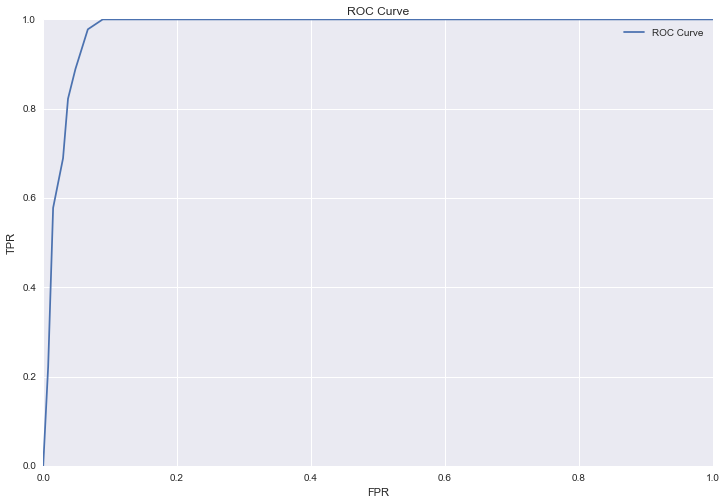

In [380]:
getROCcurve(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

#### Cross Validate and Return Scores 

In [359]:
def getScoreValuesByCV(X, y, model=KNeighborsClassifier(n_neighbors=1)):
    
    accuracy_score_value = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
    precision_score_value = np.mean(cross_val_score(model, X, y, scoring='precision', cv=5))
    recall_score_value = np.mean(cross_val_score(model, X, y, scoring='recall', cv=5))
    f1_score_value = np.mean(cross_val_score(model, X, y, scoring='f1', cv=5))
    roc_auc_value = np.mean(cross_val_score(model, X, y, scoring='roc_auc', cv=5))
    #roc_auc_value = 0  
        
    print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}\nROC AUC: {}'.format(accuracy_score_value, \
                                                                   precision_score_value, \
                                                                   recall_score_value, \
                                                                   f1_score_value,
                                                                   roc_auc_value))

In [360]:
getScoreValuesByCV(X,y)

Accuracy: 0.9589695911471916
Precision: 0.8623891866383524
Recall: 0.8653225806451614
f1: 0.8628064029582057
ROC AUC: 0.92032998657517


In [361]:
getScoreValuesByCV(X,y, model=RandomForestClassifier())

Accuracy: 0.9446971586657293
Precision: 0.8712931433442943
Recall: 0.7387096774193549
f1: 0.8070988327608382
ROC AUC: 0.9657330136921118


In [362]:
getScoreValuesByCV(X,y, model=GaussianNB())

Accuracy: 0.7207147554366313
Precision: 0.28659782556715907
Recall: 0.5798387096774194
f1: 0.38337993592387665
ROC AUC: 0.7184708855325689


In [363]:
getScoreValuesByCV(X,y, model=DecisionTreeClassifier())

Accuracy: 0.9361300709766661
Precision: 0.8115381773399015
Recall: 0.7762096774193549
f1: 0.7824170123640515
ROC AUC: 0.8676080478616452


In [364]:
getScoreValuesByCV(X,y, model=LogisticRegression())

Accuracy: 0.8627633279666205
Precision: 0.8333333333333333
Recall: 0.10221774193548387
f1: 0.18001375988992088
ROC AUC: 0.743819996922211


## Modeling with Over Sampling of Training Set

In [365]:
X = full_data[x_cols]
y = full_data['zscores']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=4444)

In [366]:
verbose = False
ratio = float(y.value_counts()[0]) / float(y.value_counts()[1])
X_train = X_train.reset_index(drop=True).as_matrix()
y_train = y_train.reset_index(drop=True).as_matrix()

smote = SMOTE(ratio=ratio, verbose=verbose)
smox, smoy = smote.fit_transform(X_train, y_train)

In [367]:
#smox

In [368]:
X_train = pd.DataFrame(smox, columns=x_cols)
y_train = pd.Series(smoy)

In [369]:
getScoreValues(X_train, X_test, y_train, y_test)

Accuracy: 0.926984126984127
Precision: 0.6774193548387096
Recall: 0.9333333333333333
f1: 0.7850467289719625


In [370]:
getScoreValues(X_train, X_test, y_train, y_test, model=RandomForestClassifier())

Accuracy: 0.9428571428571428
Precision: 0.7755102040816326
Recall: 0.8444444444444444
f1: 0.8085106382978723


In [371]:
getScoreValues(X_train, X_test, y_train, y_test, model=BernoulliNB())

Accuracy: 0.6190476190476191
Precision: 0.2222222222222222
Recall: 0.6666666666666666
f1: 0.3333333333333333


In [372]:
getScoreValues(X_train, X_test, y_train, y_test, model=GaussianNB())

Accuracy: 0.6095238095238096
Precision: 0.22916666666666666
Recall: 0.7333333333333333
f1: 0.3492063492063492


In [373]:
getScoreValues(X_train, X_test, y_train, y_test, model=DecisionTreeClassifier())

Accuracy: 0.9206349206349206
Precision: 0.6785714285714286
Recall: 0.8444444444444444
f1: 0.7524752475247526


In [374]:
getScoreValues(X_train, X_test, y_train, y_test, model=LogisticRegression())

Accuracy: 0.6444444444444445
Precision: 0.23622047244094488
Recall: 0.6666666666666666
f1: 0.3488372093023256


## Confusion Matrix

In [375]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not at Risk', 'At Risk'], rotation=45)
    plt.yticks(tick_marks, ['Not at Risk', 'At Risk'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Cross validate with or without oversampling

In [376]:
def getCrossValScoresBySSS(local_X, 
                           local_y, 
                           n_iter=30, 
                           test_size=0.3, 
                           model=KNeighborsClassifier(n_neighbors=2),
                           oversample=True,
                           get_multi_models=False,
                           get_models_avg=False,
                           get_cm=False,
                           verbose=True,
                           get_features=True
                          ):
    
    score_dict = {}
    acc_array = []
    prec_array = []
    recall_array = []
    f1_array = []
    feature_imp_array = []
    
    x_cols = list(local_X.columns)
    ratio = float(local_y.value_counts()[0]) / (float(local_y.value_counts()[1]))
    sss = StratifiedShuffleSplit(y, n_iter=n_iter, test_size=test_size)
    
    model_list = [\
                  KNeighborsClassifier(n_neighbors=2), \
                  LogisticRegression(), \
                  BernoulliNB(), \
                  GaussianNB(), \
                  RandomForestClassifier(n_estimators=30), \
                  DecisionTreeClassifier() \
                  ]
    
    #Return table of scores for each model
    if get_multi_models:
        model_acc = []
        model_prec = []
        model_rec = []
        model_f1 = []
        for a_model in model_list:
            acc_array = []
            prec_array = []
            recall_array = []
            f1_array = []
            for train_index, test_index in sss:
                #print("TRAIN:", train_index, "TEST:", test_index)
                X_train, X_test = X.ix[train_index], X.ix[test_index]
                y_train, y_test = y.ix[train_index], y.ix[test_index]
                
                if oversample:
                    X_train = X_train.reset_index(drop=True).as_matrix()
                    y_train = y_train.reset_index(drop=True).as_matrix()

                    smote = OverSampler(ratio=ratio, verbose=False)
                    smox, smoy = smote.fit_transform(X_train, y_train)
                    X_train = pd.DataFrame(smox, columns=x_cols)
                    y_train = pd.Series(smoy)
            
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, _ = getScoreValues(X_train, 
                                                                   X_test, 
                                                                   y_train, 
                                                                   y_test, 
                                                                   model=a_model, 
                                                                   verbose=False,
                                                                   get_features=False)
                
                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)
                
            mean_acc = np.mean(acc_array)
            mean_prec = np.mean(prec_array)
            mean_recall = np.mean(recall_array)
            mean_f1 = np.mean(f1_array)
            
            model_acc.append(mean_acc)
            model_prec.append(mean_prec)
            model_rec.append(mean_recall)
            model_f1.append(mean_f1)
            
        score_dict['Accuracy'] = model_acc
        score_dict['Precision'] = model_prec
        score_dict['Recall'] = model_rec
        score_dict['F1'] = model_f1
        
        col_names = ['Accuracy', 'Precision', 'Recall', 'F1']
        index_func = [\
                  'KNeighborsClassifier(n_neighbors=2)', \
                  'LogisticRegression()', \
                  'BernoulliNB()', \
                  'GaussianNB()', \
                  'RandomForestClassifier(n_estimators=30)', \
                  'DecisionTreeClassifier()' \
                  ]
        df = pd.DataFrame(score_dict, columns=col_names, index=index_func)
        return df
    
    
    else:
        for train_index, test_index in sss:
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X.ix[train_index], X.ix[test_index]
            y_train, y_test = y.ix[train_index], y.ix[test_index]

            if oversample:
                X_train = X_train.reset_index(drop=True).as_matrix()
                y_train = y_train.reset_index(drop=True).as_matrix()

                smote = SMOTE(ratio=ratio, verbose=False)
                smox, smoy = smote.fit_transform(X_train, y_train)
                X_train = pd.DataFrame(smox, columns=x_cols)
                y_train = pd.Series(smoy)

            #Get scores of the average prediction of multiple models
            if get_models_avg:
                y_predictions = []

                for a_model in model_list:
                    temp_model = a_model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)
                    y_predictions.append(y_pred)

                average_prediction = np.mean(y_predictions, axis=0)
                average_prediction = [int(round(n, 0)) for n in average_prediction]

                accuracy_score_value = accuracy_score(y_test, y_pred)
                precision_score_value = precision_score(y_test, y_pred)
                recall_score_value = recall_score(y_test, y_pred)
                f1_score_value = f1_score(y_test, y_pred)

                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)

            #Get score values for each fold
            else:
                accuracy_score_value, precision_score_value, \
                recall_score_value, f1_score_value, \
                feature_importances = getScoreValues(X_train, 
                                                     X_test, 
                                                     y_train,
                                                     y_test, 
                                                     model=model, 
                                                     verbose=False,
                                                     get_features=get_features)

                if get_cm:
                    # For getting a confusion matrix of the last model in the cross validated set
                    temp_model = model
                    model.fit(X_train, y_train)
                    y_pred = model.predict(X_test)

                acc_array.append(accuracy_score_value)
                prec_array.append(precision_score_value)
                recall_array.append(recall_score_value)
                f1_array.append(f1_score_value)
                feature_imp_array.append(feature_importances)

        if get_cm:
            try:
                cm = confusion_matrix(y_test, average_prediction)
            except:
                cm = confusion_matrix(y_test, y_pred)
            plt.figure()
            plot_confusion_matrix(cm)

        mean_acc = np.mean(acc_array)
        mean_prec = np.mean(prec_array)
        mean_recall = np.mean(recall_array)
        mean_f1 = np.mean(f1_array)
        try:
            mean_feature_imp = np.mean(feature_imp_array, axis=0)
        except TypeError:
            mean_feature_imp = None
            
            
        if verbose:
            print('Avg Feature Importance: {}'.format(mean_feature_imp))
            print('Accuracy: {}\nPrecision: {}\nRecall: {}\nf1: {}'.format(mean_acc, \
                                                                           mean_prec, \
                                                                           mean_recall,\
                                                                           mean_f1))
        else:
            return mean_acc, mean_prec, mean_recall, mean_f1

In [377]:
X = full_data[x_cols]
y = full_data['zscores']

## Scores for various models

#### With oversampling

In [378]:
getCrossValScoresBySSS(X, y, get_multi_models=True)

,Accuracy,Precision,Recall,F1
KNeighborsClassifier(n_neighbors=2),0.957778,0.850382,0.875177,0.861364
LogisticRegression(),0.672593,0.263339,0.664539,0.376911
BernoulliNB(),0.611534,0.227211,0.665957,0.338251
GaussianNB(),0.583704,0.211904,0.659574,0.320509
RandomForestClassifier(n_estimators=30),0.954074,0.851304,0.841844,0.844926
DecisionTreeClassifier(),0.927937,0.770171,0.745390,0.755615


#### Without oversampling

In [379]:
getCrossValScoresBySSS(X, y, oversample=False, get_multi_models=True)

,Accuracy,Precision,Recall,F1
KNeighborsClassifier(n_neighbors=2),0.942328,0.878067,0.716312,0.785890
LogisticRegression(),0.862434,0.833122,0.098582,0.173650
BernoulliNB(),0.809418,0.394656,0.504965,0.441844
GaussianNB(),0.726243,0.289194,0.570213,0.383060
RandomForestClassifier(n_estimators=30),0.944550,0.890825,0.718440,0.792057
DecisionTreeClassifier(),0.930899,0.774243,0.765248,0.767200


#### KNN various n


n =  1
Avg Feature Importance: None
Accuracy: 0.9458201058201058
Precision: 0.7948602674302019
Recall: 0.8645390070921984
f1: 0.8269033926918108


n =  2
Avg Feature Importance: None
Accuracy: 0.9481481481481481
Precision: 0.8164014376687819
Recall: 0.8453900709219856
f1: 0.8292594085899101


n =  3
Avg Feature Importance: None
Accuracy: 0.9202116402116403
Precision: 0.6720249068118938
Recall: 0.924822695035461
f1: 0.7770038713188918


n =  4
Avg Feature Importance: None
Accuracy: 0.9251851851851852
Precision: 0.692428253599617
Recall: 0.9063829787234045
f1: 0.7840178284414955


n =  5
Avg Feature Importance: None
Accuracy: 0.8960846560846563
Precision: 0.5998180135313383
Recall: 0.9297872340425531
f1: 0.7282970154396406


n =  6
Avg Feature Importance: None
Accuracy: 0.8959788359788361
Precision: 0.6018028637635557
Recall: 0.919148936170213
f1: 0.7258329394366858


n =  7
Avg Feature Importance: None
Accuracy: 0.8747089947089948
Precision: 0.5503666488272305
Recall: 0.9290780141843972

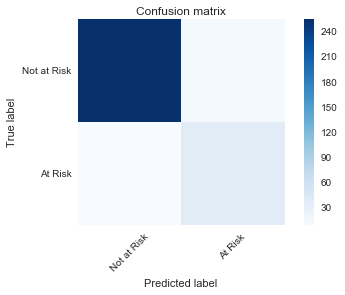

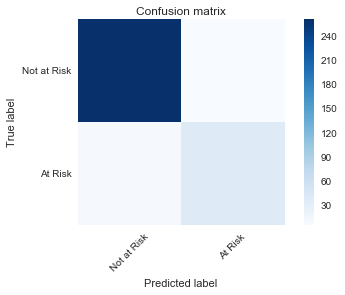

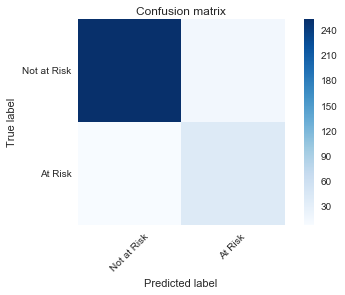

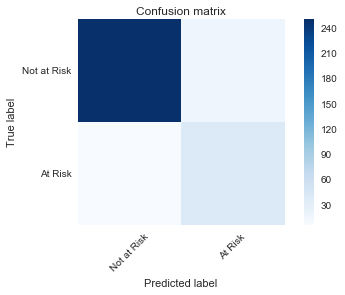

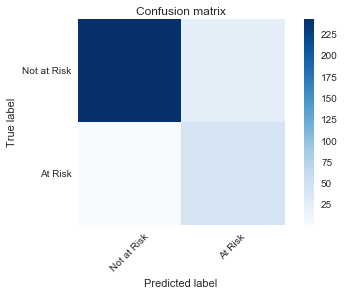

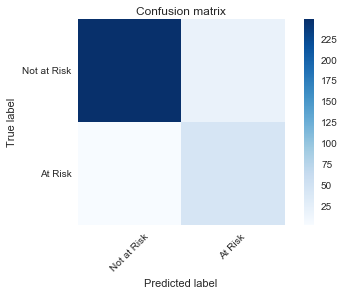

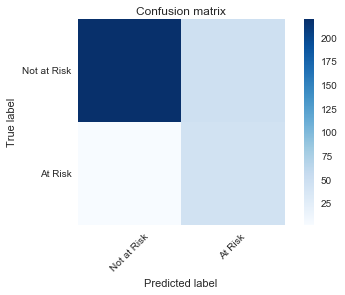

In [333]:
for n in range(1,8):
    print('n = ', n)
    getCrossValScoresBySSS(X, y, model=KNeighborsClassifier(n_neighbors=n), get_cm=True)
    print('\n')

#### Random Forest for important features

Avg Feature Importance: [ 0.14819453  0.13686984  0.18041677  0.13442049  0.16137246  0.2387259 ]
Accuracy: 0.9419047619047619
Precision: 0.7949584035052707
Recall: 0.827659574468085
f1: 0.809356330990798


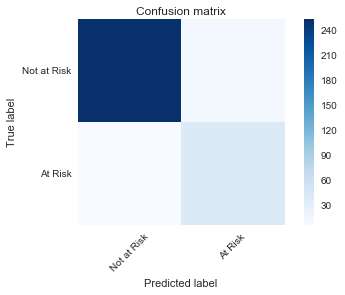

In [334]:
getCrossValScoresBySSS(X, y, model=RandomForestClassifier(n_estimators=100), get_cm = True)

Avg Feature Importance: [ 0.15352136  0.146693    0.17613569  0.13519173  0.16065024  0.22780799]
Accuracy: 0.9398941798941799
Precision: 0.784600213744724
Recall: 0.8262411347517731
f1: 0.8039317970442635


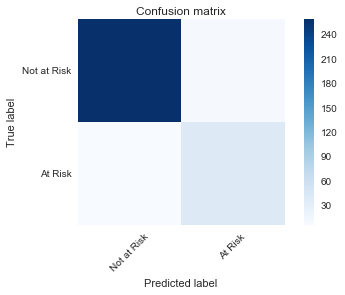

In [335]:
getCrossValScoresBySSS(X, y, model=RandomForestClassifier(n_estimators=30), get_cm = True)

#### DecisionTreeClassifier for important features

Avg Feature Importance: [ 0.11890657  0.18401878  0.20698756  0.14838128  0.12023856  0.22146724]
Accuracy: 0.9212698412698413
Precision: 0.7195010076613932
Recall: 0.782269503546099
f1: 0.7478233317462021


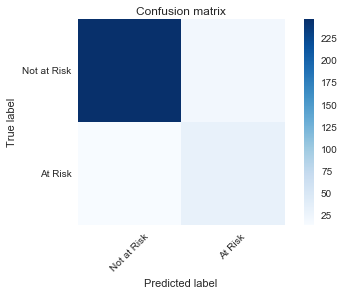

In [336]:
getCrossValScoresBySSS(X, y, model=DecisionTreeClassifier(), get_cm = True)

### Random forest, different number of trees

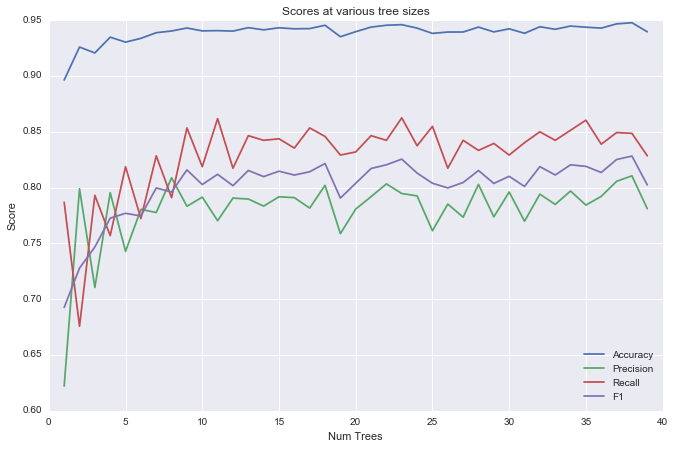

In [150]:
forest_acc = []
forest_prec = []
forest_rec = []
forest_f1 = []
forest_range = list(range(1,40))
for trees in forest_range:
    acc, prec, rec, f1 = getCrossValScoresBySSS(X, y, model=RandomForestClassifier(n_estimators=trees), verbose=False)
    forest_acc.append(acc)
    forest_prec.append(prec)
    forest_rec.append(rec)
    forest_f1.append(f1)

plt.figure(figsize=(11,7))
plt.plot(forest_range, forest_acc, label='Accuracy')
plt.plot(forest_range, forest_prec,label='Precision')
plt.plot(forest_range, forest_rec,label='Recall')
plt.plot(forest_range, forest_f1,label='F1')

plt.legend(loc='best')
plt.xlabel('Num Trees')
plt.ylabel('Score')
plt.title('Scores at various tree sizes')
plt.show()

    

### Model averages:

In [151]:
getCrossValScoresBySSS(X, y, get_models_avg=True)

Avg Feature Importance: nan
Accuracy: 0.9503086419753085
Precision: 0.8418162386708034
Recall: 0.8236111111111112
f1: 0.830627832579136


/Users/kenn/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
